# CAS Data Engineering FHNW FS2024

# Data Pipeline

### Dataset: LendingClub

Ein Kaggle-Datensatz, der auch in anderen CAS-Modulen verwendet werden wird.
Dataset link: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans
Schema infos: https://www.openintro.org/data/index.php?data=loans_full_schema
Context: Loan data for all loans issued through the time period stated in US area.
Content:Training set (data from 2007 till 2015) and test set (data from 2016 till 2017).


### imports

Note: to install pandas-profiling:

Run in notebook this command each time you start the notebook

!pip install pandas-profiling

other options: copy the requirements.txt to /root/work/ and run

pip install -r requirements.txt

In [11]:

import warnings
# Wrangling
import pandas as pd
import numpy as np

# Profiling
import missingno as msno
from ydata_profiling import ProfileReport


# Vis
import matplotlib.pyplot as plt
import seaborn as sns

from thefuzz import fuzz



## Extract Data

In [5]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [234]:
df = pd.read_csv("lc_loan_sample.csv",low_memory = False)
            

In [246]:
df.to_parquet("pippo")

## Profiling

In [211]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1069453,1303701,11000.0,11000.0,11000.0,36 months,6.62,337.75,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1067874,1302235,6000.0,6000.0,6000.0,60 months,12.69,135.57,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1057633,1289398,8450.0,8450.0,8425.0,60 months,16.77,208.97,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
profile = ProfileReport(df, title='Loan Dataset Profiling Report', minimal=True)
profile.to_file(output_file='lc_loan_sample_profiling.html')

# Some Output examples https://github.com/ydataai/ydata-profiling#-examples

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]


## Missing Data

In [95]:
def identify_cols_missing(df):
    """ Find Columns with Missing Values and Their Data Types
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        list of tuples  (column_name, data type)  of columns having missing values.
    """
    return [(column_name, df[column_name].dtype)
                        for column_name in df.columns[df.isna().any()]]
    
missings = identify_cols_missing(df)
print(f'{len(missings)} have missings')
for missing in missings:
    print(missing)

39 have missings
('emp_title', dtype('O'))
('emp_length', dtype('O'))
('annual_inc', dtype('float64'))
('desc', dtype('O'))
('title', dtype('O'))
('delinq_2yrs', dtype('float64'))
('earliest_cr_line', dtype('O'))
('inq_last_6mths', dtype('float64'))
('mths_since_last_delinq', dtype('float64'))
('mths_since_last_record', dtype('float64'))
('open_acc', dtype('float64'))
('pub_rec', dtype('float64'))
('revol_util', dtype('float64'))
('total_acc', dtype('float64'))
('last_pymnt_d', dtype('O'))
('next_pymnt_d', dtype('O'))
('collections_12_mths_ex_med', dtype('float64'))
('mths_since_last_major_derog', dtype('float64'))
('annual_inc_joint', dtype('float64'))
('dti_joint', dtype('float64'))
('verification_status_joint', dtype('O'))
('acc_now_delinq', dtype('float64'))
('tot_coll_amt', dtype('float64'))
('tot_cur_bal', dtype('float64'))
('open_acc_6m', dtype('float64'))
('open_il_6m', dtype('float64'))
('open_il_12m', dtype('float64'))
('open_il_24m', dtype('float64'))
('mths_since_rcnt_il', 

### plot missing

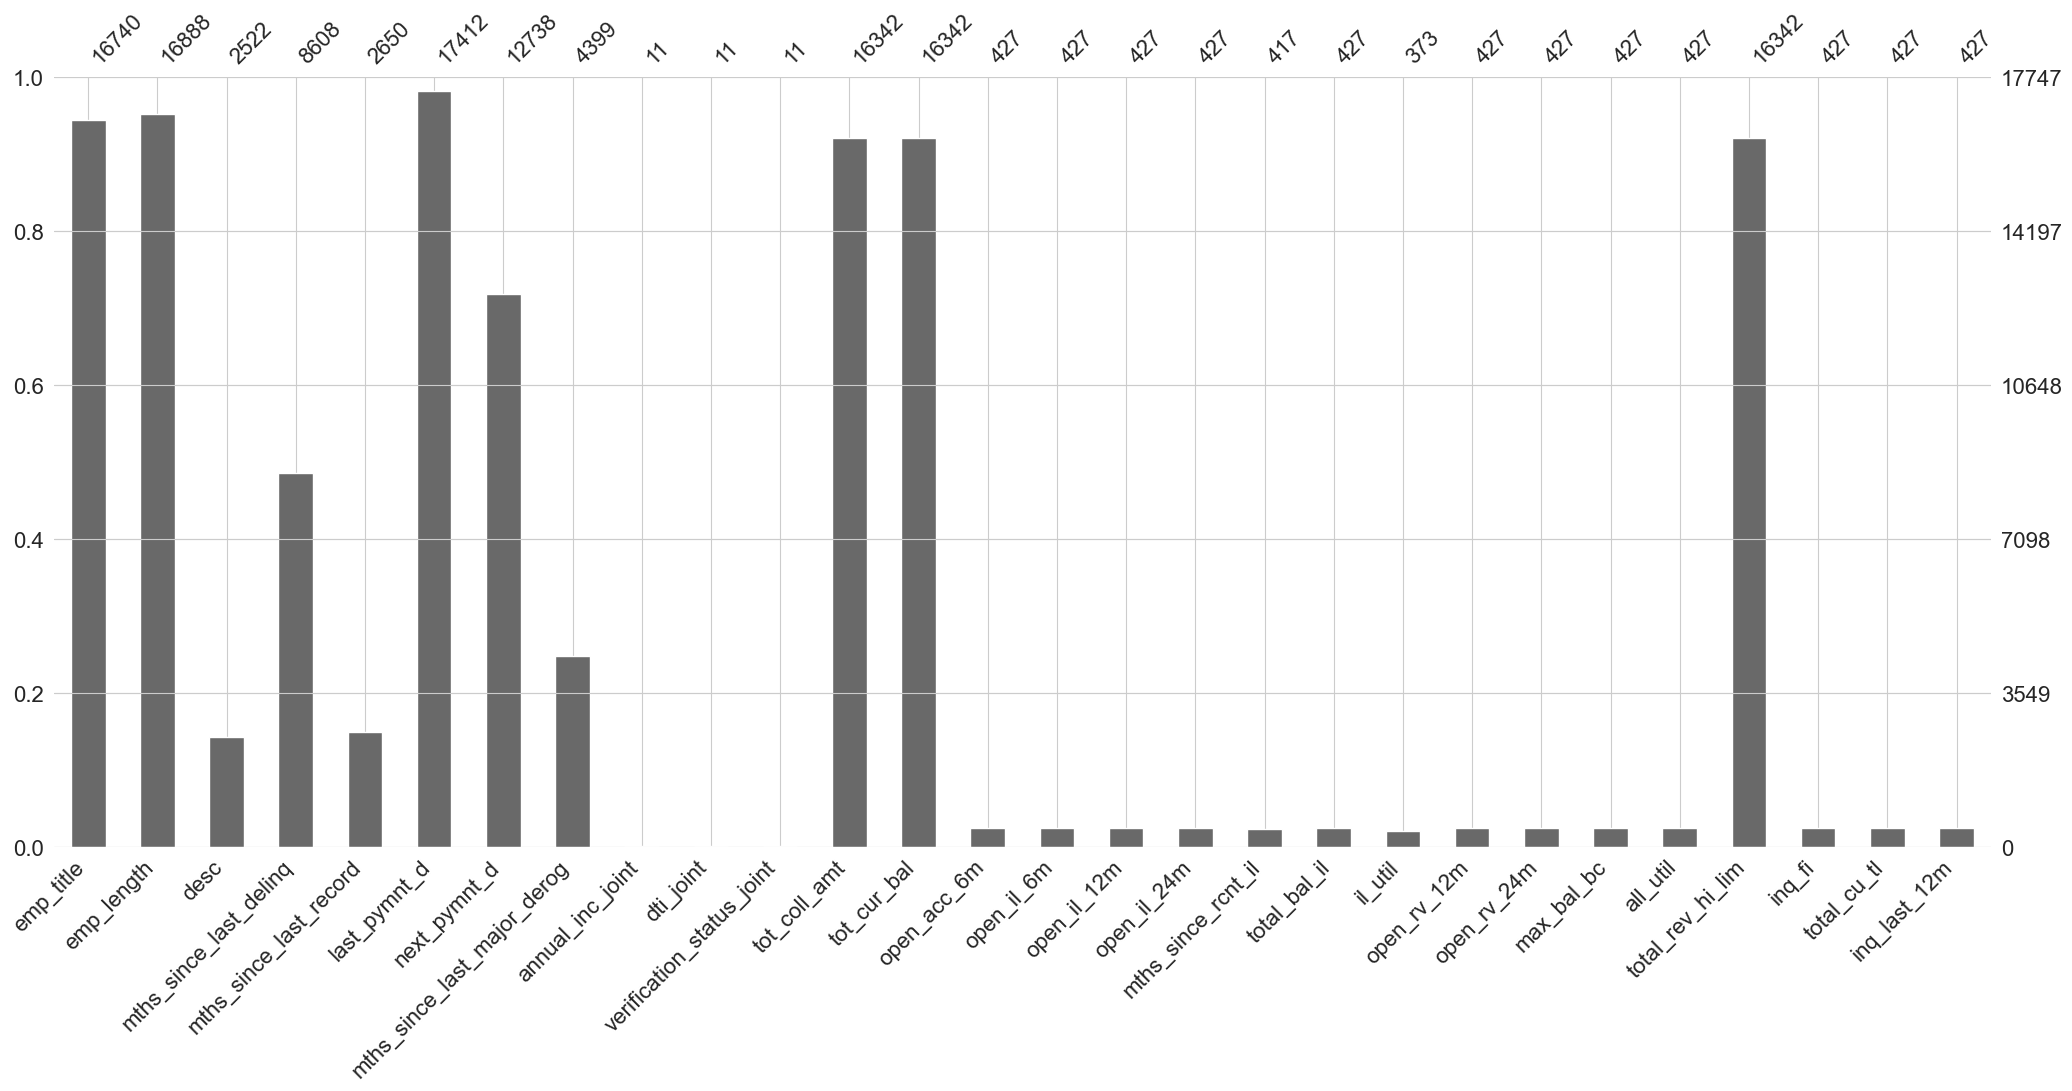

In [99]:
def plot_missing_data(df):
    """ plot Columns with Missing Values and Their Data Types
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        None
    """
    threshold = int(df.shape[0]/100)# 1percent
    missing_counts = df.isnull().sum()
    df_missing = df[missing_counts[missing_counts > threshold].index.tolist()]
    msno.bar(df_missing)
    
plot_missing_data(df)


### Single value / Constant

In [130]:
def find_constants(df):
    """ Find Columns with a cinstant value
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        List of Columns name
    """
    return df.columns[df.nunique() == 1].tolist()
find_constants(df)

['pymnt_plan', 'policy_code']

In [208]:
def find_missing_cols(df,threshold=100):
    """ Find Columns with all (or threshold) missing 
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        List of Columns name
    """
    return [col for col in df.columns if df[col].count() < threshold]



['annual_inc_joint', 'dti_joint', 'verification_status_joint']


### Inconsistent categories

In [228]:
def find_inconsistent_categories(df,col,reference_categories):
    """ Find Inconsisten categories 
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze 
        Returns:
        --------
        List of Columns name
    """
    unique_values = df[col].unique()
    return [value for value in unique_values if value not in reference_categories]
 
reference_categories = ['debt_consolidation','major_purchase','small_business','credit_card','house','home_improvement',
    'other','vacation','medical','wedding','car','renewable_energy','moving',
 #'educational'
 ]
find_inconsistent_categories(df,'purpose',reference_categories)

['educational']

### Duplicates

In [141]:
print(f"""duplicates in dataframe :{df.duplicated().sum()}""")    

duplicates in dataframe :0


## Record Linkage

### Regexp

In [159]:
url_pattern = r'^https?://(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(/\S*)?$'
assert all(df['url'].str.match(url_pattern)), "Not all URLs are valid"


### emp_title (Text)

In [181]:
#todo mixed types
sorted(df['emp_title'].astype(str).unique())[0:10]

[' Associate Professor',
 ' CUYAHOGA COUNTY sheriff dept',
 ' Manager',
 ' Systems Analyst',
 ' THE EMORY CLINIC',
 ' Yosemite Wholesale',
 ' adjunct math professor',
 ' assembler',
 ' laborer',
 ' line foreman']

In [183]:
print(f"emp_title has {df['emp_title'].nunique()} distinct values")


emp_title has 10654 distinct values


In [175]:
df['emp_title'].str.lower().str.strip().nunique()

9450

In [ ]:
pip install apache-airflow

from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime

# Define the Python functions for each step
def extract():
    try:
        # Your code for the extract step here
        print("Extract step completed successfully")
    except Exception as e:
        print(f"Extract step failed: {str(e)}")

def transform():
    # Your code for the transform step here
    print("Transform step completed successfully")

def dashboarding():
    # Your code for the dashboarding step here
    print("Dashboarding step completed successfully")

# Define default_args
default_args = {
    'owner': 'your_name',
    'start_date': datetime(2023, 1, 1),
    'depends_on_past': False,
    'retries': 1,
}

# Instantiate a DAG
dag = DAG(
    'my_workflow',
    default_args=default_args,
    schedule_interval=None,  # Set the schedule interval (e.g., '@daily')
)

# Define tasks
extract_task = PythonOperator(
    task_id='extract',
    python_callable=extract,
    dag=dag,
)

transform_task = PythonOperator(
    task_id='transform',
    python_callable=transform,
    dag=dag,
)

dashboarding_task = PythonOperator(
    task_id='dashboarding',
    python_callable=dashboarding,
    dag=dag,
)

# Define task dependencies
extract_task >> transform_task >> dashboarding_task

manually....
airflow scheduler
airflow webserver -p 8080



In [185]:
df['emp_title'].str.lower().groupby(df['emp_title'].str.lower()).size().reset_index(name='count').sort_values(by='count', ascending=False).head(20)


,emp_title,count
8719,teacher,330
5120,manager,286
7021,registered nurse,167
6020,owner,148
7180,rn,136
8530,supervisor,124
2810,driver,123
5858,office manager,110
7295,sales,102
3654,general manager,92


## Transforming and Persisting the data

### Remove Columns

In [235]:
shape_before = df.shape[1]
remove_list = ["id", "member_id"] # From Profiling: not meaning business wise
remove_list.extend(find_constants(df)) #  Constant value
remove_list.extend(find_missing_cols(df,threshold=100)) # As Missing
print(set(remove_list))
df.drop(remove_list,axis=1,inplace=True)
print(f"""Removed {shape_before - df.shape[1]} columns""")


{'annual_inc_joint', 'verification_status_joint', 'policy_code', 'id', 'dti_joint', 'member_id', 'pymnt_plan'}
Removed 7 columns


### duplicates

In [236]:

print(f"""Shape {df.shape} before""")
df.drop_duplicates(keep='first', inplace=True)#saw in profiling no duplicates
print(f"""Shape {df.shape} before""")


Shape (17747, 67) before
Shape (17747, 67) before


### Inconsistent categories

In [237]:
col = 'purpose'
reference_categories = ['debt_consolidation','major_purchase','small_business','credit_card','house','home_improvement',
    'other','vacation','medical','wedding','car','renewable_energy','moving',
 #'educational'
 ]

df['purpose'] =  df['purpose'].apply(lambda x: x if x in reference_categories else 'other')
find_inconsistent_categories(df,col,reference_categories)

# remapping
# numerical binning

[]

### Dates

In [ ]:
TODO

## Record Linkage

In [258]:
#harmonise: lower,strip, len>2, RN(quick win), regexp mgmt, business list

#group (engineer mgmt teacher), exclusion, len

# compare

before_dq = len(df['emp_title'].unique()) 

df['emp_title']=df['emp_title'].astype(str)
df['emp_title'] = df['emp_title'].str.lower().str.strip()

after_dq = len(df['title'].unique()) 

print(f"""DQ for Title: {before_dq - after_dq}  values harmonised, (current unique values {after_dq})""")

DQ for Title: 0  values harmonised, (current unique values 9451)


In [264]:
fuzz.ratio("pension consultant	", "full_name")

21

In [261]:
df['emp_title'].groupby(df['emp_title']).size().reset_index(name='count').sort_values(by='count', ascending=True).head(100)


,emp_title,count
0,1. lpn/ 2. driver,1
6069,pension consultant,1
6068,pencor services,1
6067,peer 1 network,1
6066,pediatric nurse practitioner,1
...,...,...
5951,paratransit driver,1
5950,"parata systems, llc",1
5948,paraplanner,1
5947,paramedic/firefighter,1


In [249]:
fuzz.ratio(name, full_name)

623319.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Obtaining dependency information for thefuzz from https://files.pythonhosted.org/packages/19/7d/ca50835332895beb87e663f9a610a7e0a7335b69e31177aee87acc3db9bd/thefuzz-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.0.0 from https://files.pythonhosted.org/packages/98/cd/db33c33b1eb5618ae621a3071d4bc66f4bd1deeecb3099aa340b6043be37/rapidfuzz-3.3.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.0 MB/s eta 0:00:0000:0100:01


## Persist

In [248]:
df.to_parquet('lc_loan_sample.parquet.gzip',compression='gzip')

## EDA (Exploration data analysis)

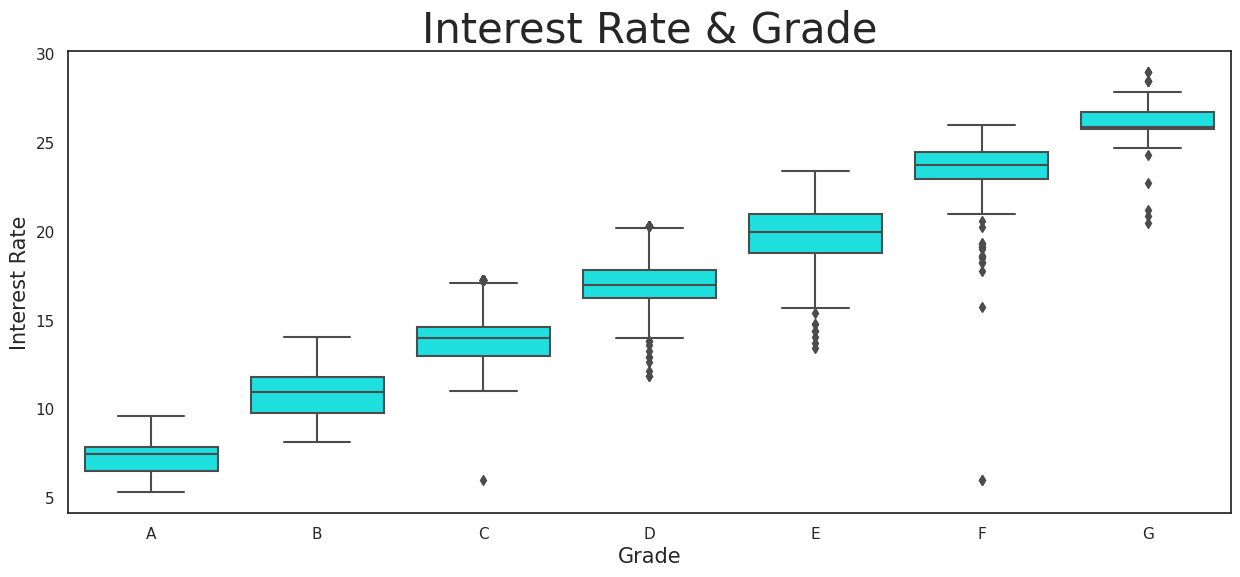

In [ ]:
sns.set_style('white')
sns.boxplot(x="grade",
            y="int_rate", 
            data=df, 
            order = "ABCDEFG",
            color='cyan'            )
plt.title("Interest Rate & Grade", fontsize=30)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest Rate", fontsize=15);

Text(0, 0.5, 'Loan Status')

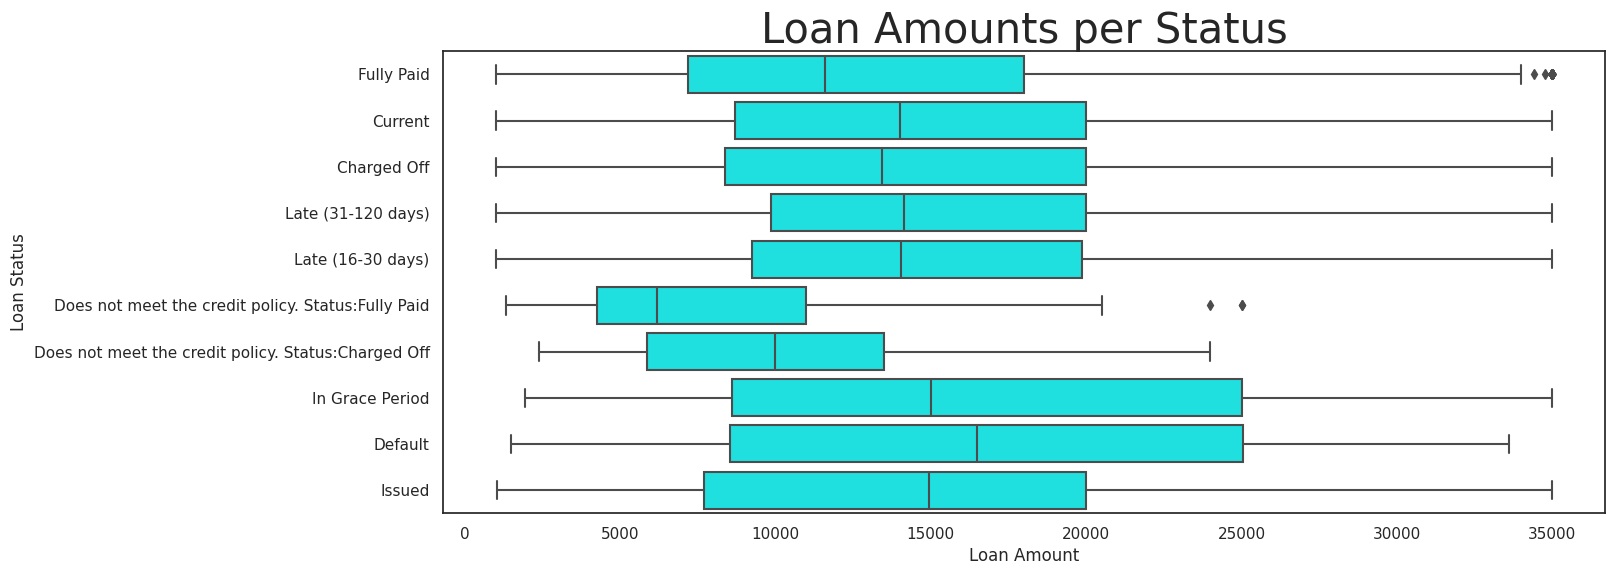

In [ ]:
ax = sns.boxplot(x='loan_amnt', y='loan_status', data=df,color="cyan")   
ax.set_title('Loan Amounts per Status',size=30)
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Loan Status')